<p></p>

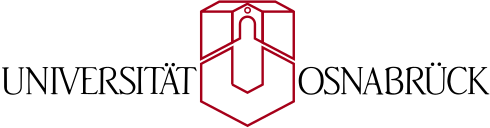
# <center>Einführung in die Künstliche Intelligenz</center> <a class="tocSkip">
### <center>Wintersemester 2020/21</center> <a class="tocSkip">
<center>Prof. Dr. Joachim Hertzberg, Felix Igelbrink, Alexander Mock</center>

# Übungsblatt 3: Constraint Satisfaction Problems

## Aufgabe: Constraint Satisfaction

Constraint Satsfaction erlaubt das Folgern und Ableiten von Zuweisungen an Variablen, die konsistent bzw.
inkonsistent mit den Bedingungen (constraints) der Zielkonfiguration sind. Die Bedingungen werden durch
Gleichungen und Ungleichungen repräsentiert. Zwei Constraint Propagation Methoden sollen im Folgen-
den untersucht werden: Backtracking und arc consistency. Die Verfahren unterscheiden sich bezüglich ihrer
Vollständigkeit der Inferenz und ihres Rechenaufwandes.

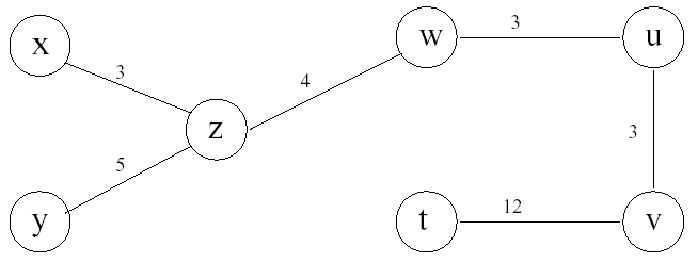

Betrachten Sie nun obiges Constraintnetz. Jeder Knoten stellt eine Variable dar und jede Kante (arc) ist
mit einer Zahl beschriftet. Die Variablen können nur Zahlen zwischen $0$ und $9$ annehmen (inklusive $0$ und
$9$). Jede Kante repräsentiert eine Bedingung, die die beiden durch die Kante verbundenen Variablen erfüllen
müssen. Die Bedingung besteht darin, dass jede Variable den gleichen Wert modulo der Kantenzahl haben
muss. Zum Beispiel repräsentiert die Kante $(x, z)$ mit dem Wert $3$ die Bedingung: $x$ mod $3$ = $z$ mod $3$ .
Sie kann erfüllt werden durch die Zuweisungen $x = 2$, $z = 2$, oder $x = 5$, $z = 2$ oder $x = 7$, $z = 1$.
Für obigen Graphen seien die Belegungen $x = 2$, $y = 0$ und $t = 0$ bereits vorhanden. 


### 
Geben Sie die Variablenbelegungen für *backtracking* an.

Bedingungen:
###################
x % 3 == z % 3
y % 5 == z % 5
z % 4 == w % 4
w % 3 == u % 3
u % 3 == v % 3
v % 12 == t % 12
x, y, z, u, v, w, t elementof [0..9]
###################

x = 2
y = 0
t = 0

=> z % 3 == 2 && z % 5 == 0
=> z = 5

=> w % 4 == 1
=> w = 5

=> u % 3 == 2
=> u = 5

=> v % 3 == 2
=> v = 5

=> v % 12 == t % 12
=> 0 == 0 correct

Es ergibt sich also die Variablenbelegung: 
(x = 2, y = 0, z = 5, w = 5, u = 5, v = 5, t = 0)

### 
Geben Sie die Variablenbelegungen für *arc consistency* an.

x = 2, y = 0, t = 0 feste Variablen
z = ?, w = ?, u = ?, v = ? freie Variablen

Constraint Queue Q = [
    x % 3 == z % 3
    y % 5 == z % 5
    z % 4 == w % 4
    w % 3 == u % 3
    u % 3 == v % 3
    v % 12 == t % 12
]

z = (0, 1, 2, 3, 4, 5, 6, 7, 8, 9)
aus 2 == z % 3 && 0 == z % 5 folgt
=> z = (2, 5)

Q = [
    z % 4 == w % 4
    w % 3 == u % 3
    u % 3 == v % 3
    v % 12 == t % 12
]

w = (0, 1, 2, 3, 4, 5, 6, 7, 8, 9)
für z = 2 => 0 == w % 4 => w = (0, 4, 8)
für z = 5 => 1 == w % 4 => w = (1, 5, 9)
=> w = (0, 1, 4, 5, 8, 9)

Q = [
    w % 3 == u % 3
    u % 3 == v % 3
    v % 12 == t % 12
]

u = (0, 1, 2, 3, 4, 5, 6, 7, 8, 9)
für w = (0, 9) => 0 == u % 3 => u = (0, 3, 6, 9)
für w = (1, 4) => 1 == u % 3 => u = (1, 4, 7)
für w = (5, 8) => 2 == u % 3 => u = (2, 5, 8)
=> u = (0, 1, 2, 3, 4, 5, 6, 7, 8, 9)

Q = [
    u % 3 == v % 3
    v % 12 == t % 12
]

da u = (0, 1, 2, 3, 4, 5, 6, 7, 8, 9)
=> v = (0, 1, 2, 3, 4, 5, 6, 7, 8, 9) kann nicht reduziert werden

und weil [0..9] % 12 == 0 ist das letzte Constraint unnötig

AC reduziert die Domänen also auf:

x = (2)
y = (0)
t = (0)
z = (2, 5)
w = (0, 1, 4, 5, 8, 9)
u = (0, 1, 2, 3, 4, 5, 6, 7, 8, 9)
v = (0, 1, 2, 3, 4, 5, 6, 7, 8, 9)

## Programmieraufgabe: CSP-Solver

In dieser Aufgabe werden Sie einen einfachen CSP-Solver selbst in Python implementieren. Dazu steht Ihnen unten erneut eine Programmiervorlage zur Verfügung. Diese Implementiert unter anderem eine Problemrepräsentation sowie eine Basisklasse für die von Ihnen zu implementierenden Constaints.

*Hinweis*: Um die benötigten Datentypen besser zu visualisieren, haben wir hier *Type-Hints* verwendet, welche die Funktionsparameter und Variablen mit Typbezeichnungen versehen. Diese werden, anders als in Sprachen wie C++ oder Java **nicht** vom Python-Interpreter erzwungen, können aber als Hinweise dienen, welche Parameter hier übergeben werden sollen.


In [1]:
from typing import Generic, TypeVar, Dict, List, Optional
from abc import ABC, abstractmethod

# Type hints
V = TypeVar('V') # variable type (any object)
D = TypeVar('D') # domain type (any object)
  
  
class Constraint(Generic[V, D], ABC):
    """
    Base class for all constraints
    """
    def __init__(self, variables: List[V]) -> None:
        """
        Init the Constraint with the Variables it's between
        """
        self.variables = variables
  
    @abstractmethod
    def satisfied(self, assignment: Dict[V, D]) -> bool:
        """
        Must be overridden by subclasses
        """
        


class CSP(Generic[V, D], ABC):
    """
    Class representing a constaint satisfaction problem.
    A constraint satisfaction problem consists of variables of type V
    that have ranges of values known as domains of type D and constraints
    that determine whether a particular variable's domain selection is valid
    """
    def __init__(self, variables: List[V], domains: Dict[V, List[D]]) -> None:
        # list of variables to be constrained
        self.variables: List[V] = variables 
        # domain of each variable
        self.domains: Dict[V, List[D]] = domains 
        self.constraints: Dict[V, List[Constraint[V, D]]] = {}
        for variable in self.variables:
            self.constraints[variable] = []
            if variable not in self.domains:
                raise LookupError("Every variable should have a domain assigned to it.")
  
    def add_constraint(self, constraint: Constraint[V, D]) -> None:
        for variable in constraint.variables:
            if variable not in self.variables:
                raise LookupError("Variable in constraint not in CSP")
            else:
                self.constraints[variable].append(constraint)
                
    def consistent(self, variable: V, assignment: Dict[V, D]) -> bool:
        """
        Check if the value assignment is consistent by checking all constraints
        for the given variable against it
        """
        for constraint in self.constraints[variable]:
            if not constraint.satisfied(assignment):
                return False
        return True
    
    @abstractmethod
    def solve(self, assignment: Dict[V, D] = {}) -> Optional[Dict[V, D]]:
        """
        Abstract method to solve the CSP. Must be implemented by subclasses.
        
        assignment is an optional partial assignment of the variables used for recursion is required.
        """


### 
Implementieren zunächst Sie eine `Constraint`-Subklasse für das in der Vorlesung behandelte Färbeproblem.
<div>
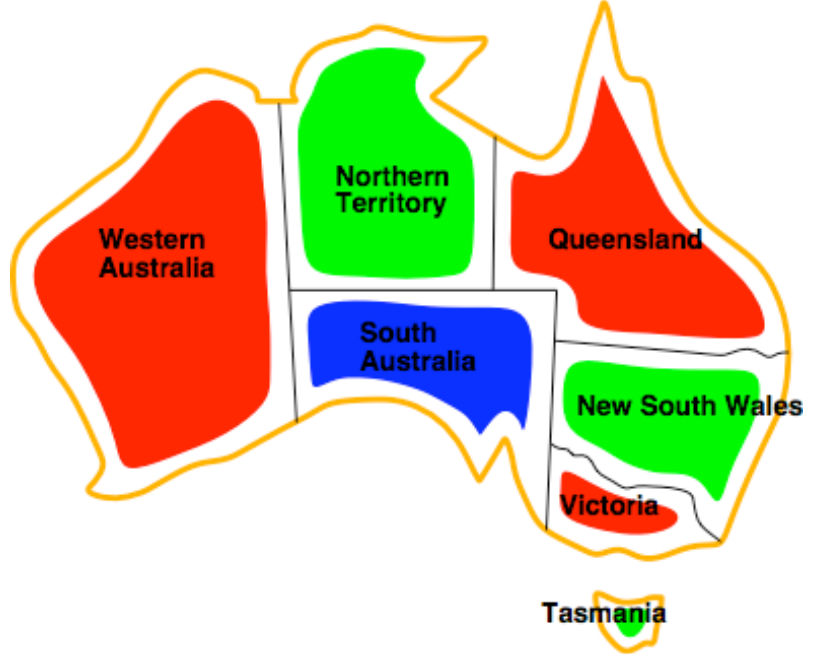 
</div>

Ihre Subklasse sollte dazu von der Klasse `Constraint` erben und die abstrakte Methode `satisfied` implementieren.

*Hinweis*: durch Aufruf von `super()` können Sie auf Methoden der Oberklasse zugreifen. Dieses ist inbesondere wichtig, um den Konstruktor (`__init__`) der Basisklasse aufzurufen (Beispiel: `super().__init__(variables)`)

In [15]:
class ColoringConstraint(Constraint):
    
    def __init__(self, variables: List[str]) -> None:
        super().__init__(variables)
        
    def satisfied(self, assignment: Dict[str, str]) -> bool:
        existing_colors = set()
        
        # all variables need to have a different assignment to be satisfied
        for variable in super().variables:
            color = assignment[variable]
            if color not in existing_colors:
                existing_colors.add(color)
            else:
                return False
        
        return True

### 
Implementieren Sie nun einen Solver, der das Färbeproblem mittels Backtracking löst. Die entsprechende Subklasse ist unten bereits vordefiniert. Sie müssen die Implementation der Methode `solve` vervollständigen.  

In [ ]:
class BacktrackingCSP(CSP):
    def solve(self, assignment: Dict[V, D] = {}) -> Optional[Dict[V, D]]:
        
        variables = super().variables
        domains = super().domains
        constraints = super().constraints
        solution = Dict[V, D]
        cur_index = len(variables) - 1
        found = False
        
        while not found:
            current_var = variables[cur_index]
        
        return None

### 
Implementieren Sie nun das Färbeproblem mit Ihrer Constraint-Klasse und nutzen Sie Ihren Solver um das Problem zu lösen.

In [ ]:
variables: List[str] = ["Western Australia", "Northern Territory", "South Australia",
                         "Queensland", "New South Wales", "Victoria", "Tasmania"]
domains: Dict[str, List[str]] = {}

#TODO: INSERT YOUR CODE HERE

       row_vals = set()
        for item in row:
            if item in solution:
                row_vals.add(solution[item])
                
        col_vals = set()
        for item in col:
            if item in solution:
                col_vals.add(solution[item])
                

## Programmieraufgabe: Sudoku

Nutzen Sie Ihren CSP-Solver um das Spiel [Sudoku](https://de.wikipedia.org/wiki/Sudoku) zu lösen. Einen Zufallsgenerator für Sudokus können Sie mit dem Kommando

```bash
conda install pip
pip install sudokugen 
```

installieren und wie unten gegeben benutzen.

### 
Gegeben sei zunächst folgendes Sudoku-Feld:
```
 |1 3 5 | 7 9 2 | 4 6 8|
 |0 0 0 | 0 0 0 | 0 0 0|
 |0 0 0 | 0 0 0 | 0 0 0|
 |------|-------|------|
 |0 0 0 | 0 0 0 | 0 0 0|
 |0 0 0 | 0 0 0 | 0 0 0|
 |0 0 0 | 0 0 0 | 0 0 0|
 |------|-------|------|
 |0 0 0 | 0 0 0 | 0 0 0|
 |0 0 0 | 0 0 0 | 0 0 0|
 |2 4 6 | 8 1 2 | 5 7 9|
```

Wir suchen nach einer Lösung. Wie hoch ist der erste Verzweigungsfaktor im Suchbaum?

In [ ]:
Anzahl freie Felder in den mittleren Blöcken: 3*9 = 27

Für jedes dieser Felder sind 7 Zahlen möglich im ersten Schritt.

=> 7*27 = 189

Anzahl der anderen Felder: 4*9 = 36

Für die anderen Felder sind jeweils noch 9 - 3 -1 = 5 Zahlen möglich.

=> 5*36 = 180

Also ist der erste Verzweigungsgrad 189 +180 = 369

In [ ]:
import numpy as np
from sudokugen.generator import generate, Difficulty

# level = Difficulty.EASY
level = Difficulty.MEDIUM
# level = Difficulty.HARD

(A,B) = generate(difficulty=level)
board = np.array(A).reshape(9,9)
solution = np.array(B)

print('Board:')
print(board)
print('Provided Solution:')
print(solution)

### 
Nutzen Sie Ihre Implementation aus der vorherigen Aufgabe um eine CSP-Definition für Sudoku zu schreiben und eine Lösung auszugeben. 
Implementieren Sie Ihre Constraints wieder als Subklassen der `Constraint`-Klasse. Wenn Sie Ihren Backtracking-Solver aus der vorherigen Aufgabe korrekt implementiert haben, können Sie diesen ohne Änderungen weiterhin verwenden.

In [ ]:
#TODO: INSERT YOUR CODE HERE


In [ ]:
#TODO: INSERT YOUR CODE HERE


### 
Sie werden für komplexere Sudokus (Difficulty `MEDIUM` oder `HARD`) feststellen, dass der reguläre Backtracking-Solver sehr lange benötigt. Erweitern Sie Ihren CSP-Solver um den lokalen-Konsistenz-Algorithmus `AC3` aus der Vorlesung zur Reduzierung des Suchraums. Vergleichen Sie die Laufzeiten zur Lösung der Sudokus mit und ohne `AC3`.

In [ ]:
#TODO: INSERT YOUR CODE HERE


### Zusatzaufgabe
Im Paket [python-constraint](https://pypi.org/project/python-constraint/) finden Sie optimierte Implementationen der gängigen CSP-Solver. Das Paket können Sie mit 

```bash
conda install python-constraint
```

installieren.

Nutzen Sie die Funktionen des neuen Paketes um eine optimierte Variante des Sudoku-Solvers zu implementieren, welche nicht nur eine, sondern **alle** möglichen Lösungen zurückliefert. Geben Sie die Anzahl der ermittelten Lösungen an.

In [ ]:
import constraint as csp
#TODO: INSERT YOUR CODE HERE


In [ ]:
#TODO: INSERT YOUR CODE HERE


In [ ]:
#TODO: INSERT YOUR CODE HERE
